# Testing Geopandas as Matplot

Aiming to learn how to use Geopandas and Matplot, I am using this notebook for following along an article from Alex Rich on Medium, [Use Python geopandas to make a US map with Alaska and Hawaii](https://medium.com/@alex_44314/use-python-geopandas-to-make-a-us-map-with-alaska-and-hawaii-39a9f5c222c6). That will help me on generating my charts on the main notebook for plotting airports in a map.

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Polygon
import missingno as msno
import os
import wget
import openpyxl
import math
import geodatasets

In [6]:
# download the data excel file from the USDA website to local folder
filename = "mapdata2021.xlsx"  #wget.download("https://www.ers.usda.gov/media/rbmpu1zi/mapdata2021.xlsx")

In [7]:
# load the excel file into a pandas dataframe & skip header rows
df = pd.read_excel(filename,skiprows=4)
df.head()

,Unnamed: 0,Number,Number.1,Percent,Unnamed: 4,Percentage points,Percent.1,Unnamed: 7,Percentage points.1
0,U.S.,130708000.0,98794.0,10.4,NaN,0.19,4.0,NaN,0.13
1,AK,269000.0,1203.0,9.5,,1.93,4.0,,1.35
2,AL,2039000.0,1764.0,13.1,*,2.12,4.6,,1.15
3,AR,1289000.0,1728.0,15.0,*,1.86,6.3,*,1.05
4,AZ,2929000.0,1624.0,10.1,,1.77,3.1,,0.86


In [8]:
# rename the columns of interest
df = df.rename(columns={'Unnamed: 0':'state', 'Percent':'pct_food_insecure'})

In [9]:
# retain only the columns of interest
df = df[['state','pct_food_insecure']]

<Axes: >

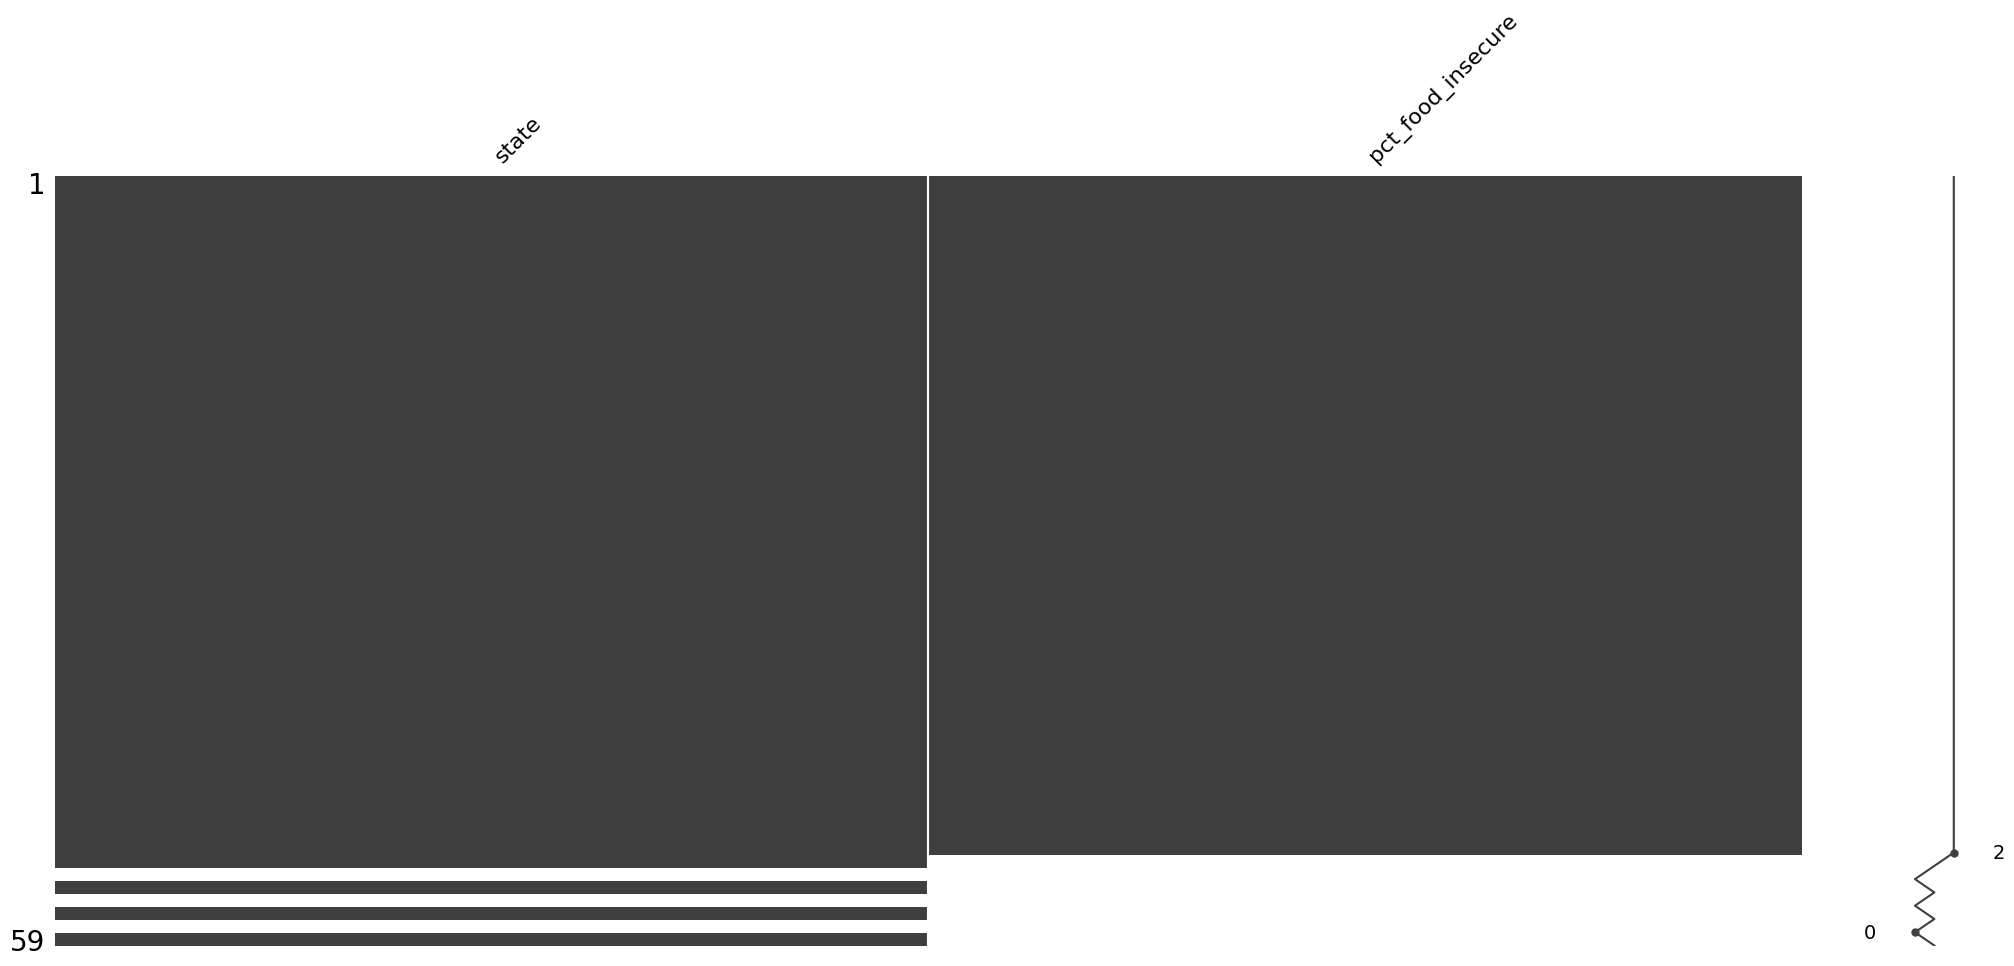

In [10]:
# take a look at the dataframe for missing values
msno.matrix(df)

In [11]:
df.tail(10)

,state,pct_food_insecure
49,WI,9.9
50,WV,14.0
51,WY,11.2
52,*Difference from U.S. average was statisticall...,NaN
53,NaN,NaN
54,1Totals exclude households for which food secu...,NaN
55,NaN,NaN
56,2Margin of error with 90 percent confidence (1...,NaN
57,NaN,NaN
58,"Source: USDA, Economic Research Service using ...",NaN


We will get rid of the last 7 rows and also from the first row, keeping the interest in the rows with two letters states:

In [12]:
df = df[df.state.str.len()==2]
df.head()

,state,pct_food_insecure
1,AK,9.5
2,AL,13.1
3,AR,15.0
4,AZ,10.1
5,CA,9.6


Let's check the data distribution

<Axes: >

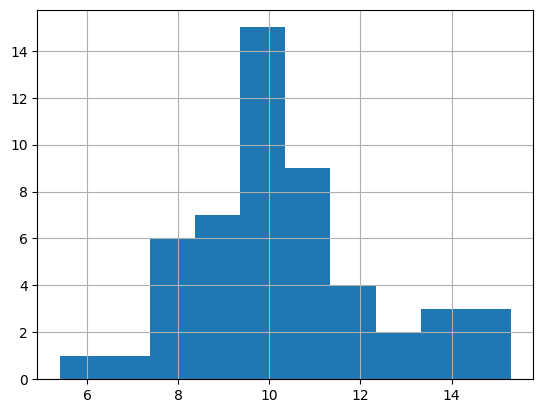

In [13]:
df.pct_food_insecure.hist()

Now we need to retrieve the Shapefile for working with Geopandas. We can get shapefiles from multiple sources online. On the article I am following, the author takes it from US Census website:

In [14]:
# wget.download("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip")

'cb_2018_us_state_500k.zip'

After downloading it, unzip the file inside a folder on your environment, then refer this Shapefile folder so Geopandas can do its thing.

In [15]:
gdf = gpd.read_file('us_state_500k')
gdf.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21524, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00256 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.6432 38.16909, -82.643 38.16956,..."


Notice how Geopandas can by itself interpret the Shapefile folder contents.

Now we merge the initial pandas dataframe we have with the geopandas dataframe using the states abbreviations as key

In [16]:
gdf = gdf.merge(df,left_on='STUSPS',right_on='state')
gdf.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,state,pct_food_insecure
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21524, -88.49176 ...",MS,15.3
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...",NC,10.9
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00256 36.52659, -103.00219 36.6...",OK,13.8
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ...",VA,7.8
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.6432 38.16909, -82.643 38.16956,...",WV,14.0


If we simply plot the map, we will have a very small map in a big canvas...

<Axes: >

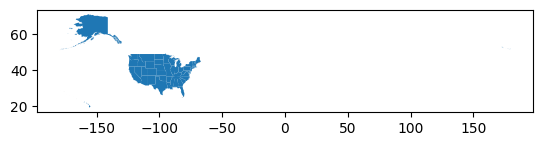

In [17]:
gdf.plot()

### A small explanation on how to focus the map in parts of interest

If we don't customize the presentation, the map displays the whole globe's longitude. So the author uses the shapely package alongside geopandas and matplotlib functions to adjust the presentation.
The visual representation and explanation is very nice:

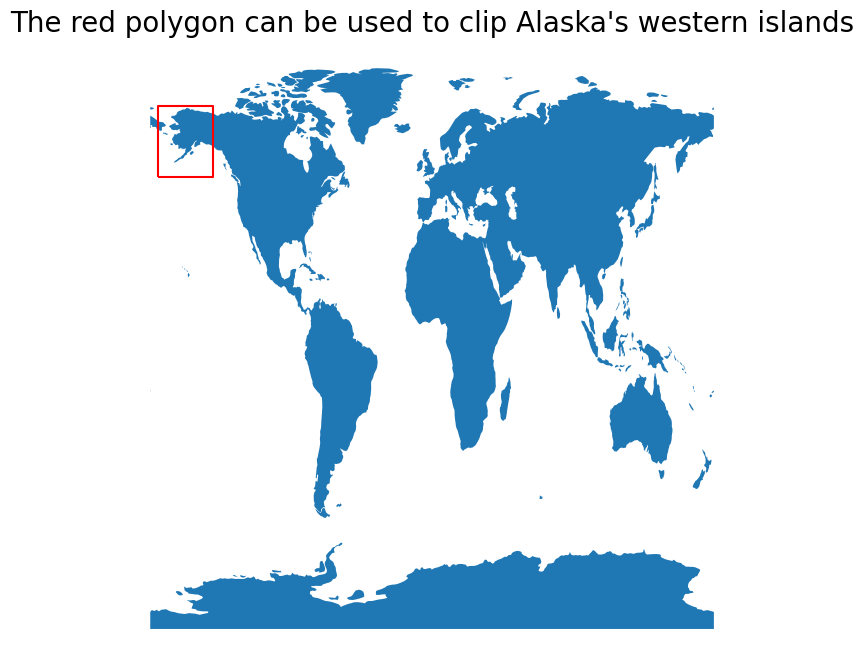

In [27]:
# Loads the whole globe shapefile
world = gpd.read_file(geodatasets.get_path("naturalearth.land"))

# The convention for polygon points is (Long, Lat)
# Defines a poligon(squared) around Alaska.
polygon = Polygon([(-175,50),(-175,72),(-140, 72),(-140,50)])

# Initializes the Geodataframe with the polygon coordinates using the world map's Coordinate Reference System
poly_gdf = gpd.GeoDataFrame( geometry=[polygon], crs=world.crs)

fig, ax1 = plt.subplots(1, figsize=(8, 18))

# Plots the world map
world.plot(ax=ax1)

# Plots the squared polygon
poly_gdf.boundary.plot(ax = ax1, color="red")

ax1.set_title("The red polygon can be used to clip Alaska's western islands", fontsize=20)
ax1.set_axis_off()
plt.show()

Now that we saw how to use polygons in a piece of the map, we clip Alaska's territory:

<Axes: >

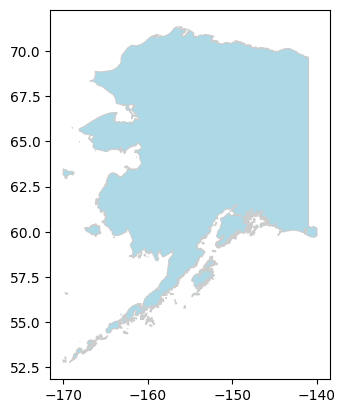

In [30]:
polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])

alaska_gdf = gdf[gdf.state == 'AK']

alaska_gdf.clip(polygon).plot(color='lightblue', linewidth=0.8, edgecolor='0.8')

The "clip" function is important to focus the map on the piece you are interested in. See it without it:

<Axes: >

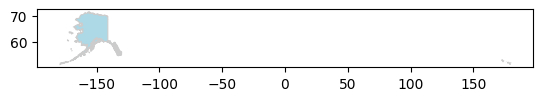

In [31]:
alaska_gdf.plot(color='lightblue', linewidth=0.8, edgecolor='0.8')

It is worth noting the explanation around CRS (Coordinate Reference Systems), and how it affects the projections of our maps. Take a look on the article for some links to dive deeper in the matter.

The thing is, the best projection to use depends on what you are trying to do. Geopandas makes it easy for us to change the projects according to our needs. For example:
```gdf.to_crs({'init':'epsg:2163'})```

### Back to the main thread...

Now, we want to start preparing our map plotting with the main continental USA, but with boxes reserved for AK and HI in the bottom left corner. That will allow us to visualize all territory in a good space.

Also, for having a more realistic view of the territory, we will use a different projection from the previous "world.crs".

In order to not break our original dataframe, we create a copy of it from the to_crs function.

/home/fernando/anaconda3/envs/datasciencepython/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


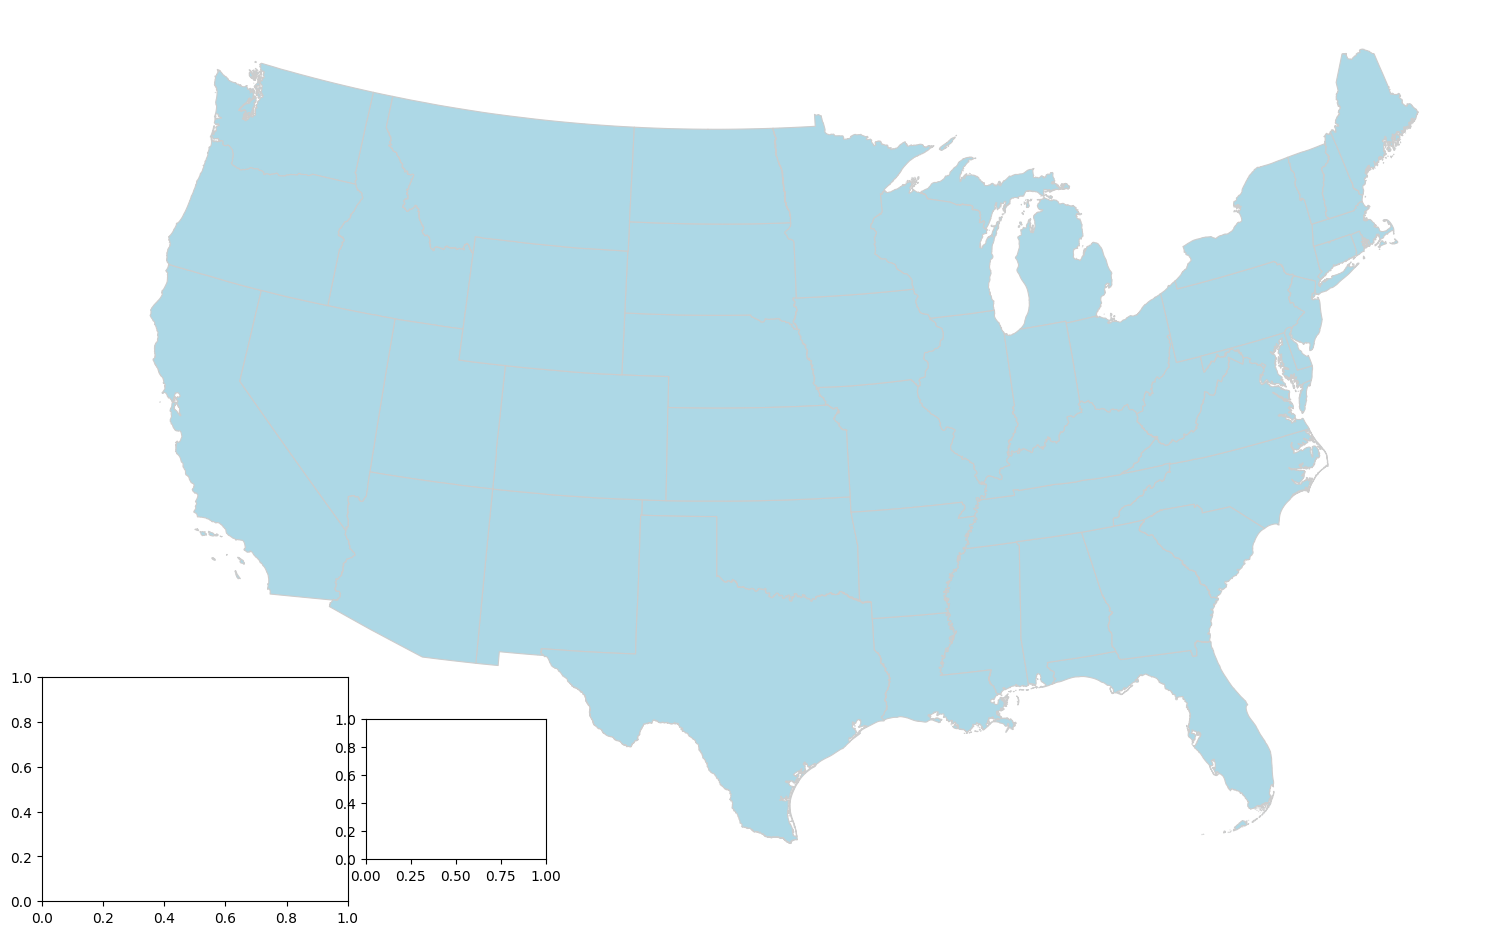

In [32]:
visframe = gdf.to_crs({"init": "epsg:2163"})

# create figure and axes with Matplotlib for the main map
fig, ax = plt.subplots(1, figsize=(18, 14))
# remove the axis box from the main map
ax.axis('off')

# create map of all states except AK and HI in the main map axis
visframe[~visframe.state.isin(['HI','AK'])].plot(color='lightblue', linewidth=0.8, ax=ax, edgecolor='0.8')

# Add Alaska Axis(a box) (x, y, width, height)
akax = fig.add_axes([0.1, 0.17, 0.17, 0.16])   

# Add Hawaii Axis(a box) (x, y, width, height)
hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])

Before plotting everything, the author creates a function to give each state a different color based on a specific variable. That allows the visualization of the data values across the whole country map, where smaller values have a lighter color, while high values tend to a darker color.

This approach for coloring the map was needed given that the plot is formed by 3 different plots, which would cause the colors to not follow the same "rate of assignment" between the maps. For example, a value 5 on AK could endup having a different color than on the Continental map, as it would have no other to be compared with.

In [33]:
# Apply this to the gdf to ensure all states are assigned colors by the same func
def makeColorColumn(gdf,variable,vmin,vmax):
    # apply a function to a column to create a new column of assigned colors & return full frame
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.YlOrBr)
    gdf['value_determined_color'] = gdf[variable].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
    return gdf

Now we apply the coloring function on our geodataframe

In [34]:
# set the value column that will be visualised
variable = 'pct_food_insecure'

# make a column for value_determined_color in gdf
vmin, vmax = gdf.pct_food_insecure.min(), gdf.pct_food_insecure.max()
# Choose the continuous colorscale "YlOrBr" from https://matplotlib.org/stable/tutorials/colors/colormaps.html
colormap = "YlOrBr"
gdf = makeColorColumn(gdf,variable,vmin,vmax)

Redefining the projection now with the updated GDF

In [35]:
visframe = gdf.to_crs({'init':'epsg:2163'})

/home/fernando/anaconda3/envs/datasciencepython/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Now we plot it all...

/tmp/ipykernel_348/3981024951.py:52: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  hawaii_gdf.clip(hipolygon).plot(column=variable, color=hawaii_gdf['value_determined_color'], linewidth=0.8,ax=hiax, edgecolor='0.8')


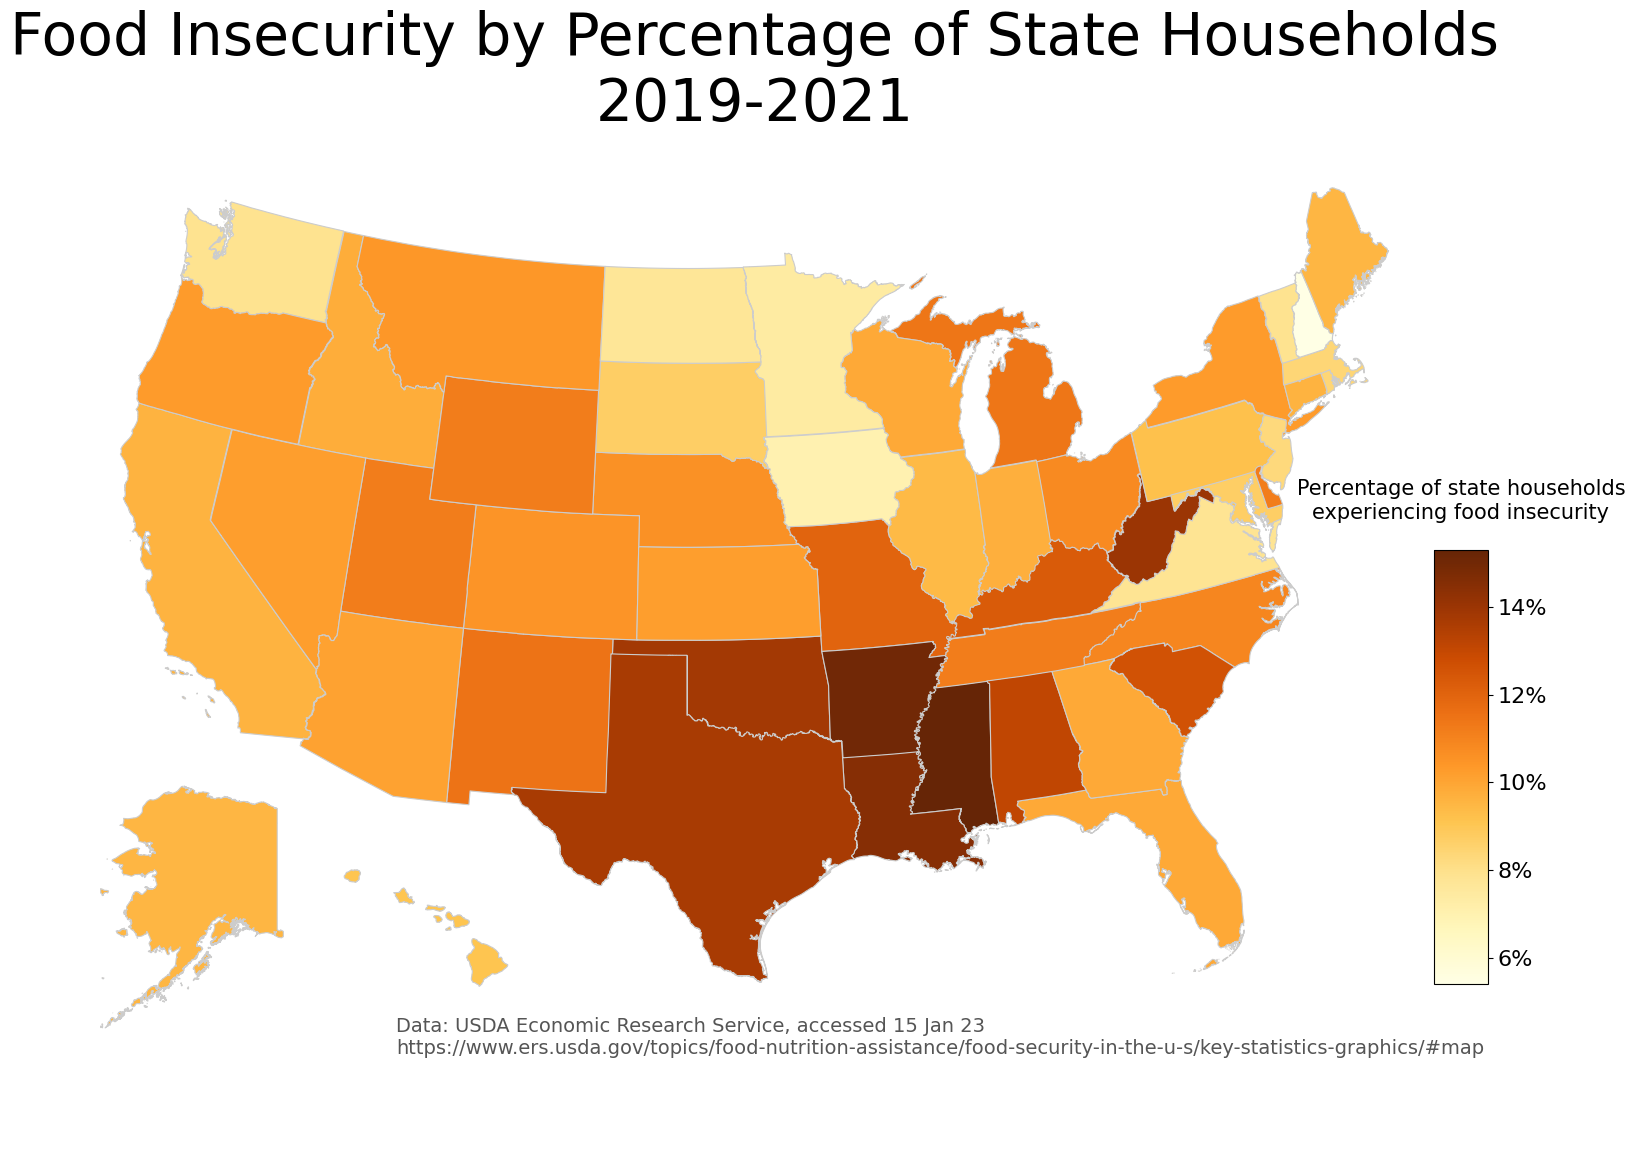

In [39]:
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(18, 14))
# remove the axis box around the vis
ax.axis('off')

# add a title and annotation
ax.set_title('Food Insecurity by Percentage of State Households\n2019-2021', fontdict={'fontsize': '42', 'fontweight' : '1'})

# Create colorbar legend
fig = ax.get_figure()
# add colorbar axes to the figure
# This will take some iterating to get it where you want it [l,b,w,h] right
# l:left, b:bottom, w:width, h:height; in normalized unit (0-1)
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])   

cbax.set_title('Percentage of state households\nexperiencing food insecurity\n', fontdict={'fontsize': '15', 'fontweight' : '0'})

# add color scale
sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
# reformat tick labels on legend
sm._A = []
comma_fmt = FuncFormatter(lambda x, p: format(x/100, '.0%'))
fig.colorbar(sm, cax=cbax, format=comma_fmt)
tick_font_size = 16
cbax.tick_params(labelsize=tick_font_size)
# annotate the data source, date of access, and hyperlink
ax.annotate("Data: USDA Economic Research Service, accessed 15 Jan 23\nhttps://www.ers.usda.gov/topics/food-nutrition-assistance/food-security-in-the-u-s/key-statistics-graphics/#map", xy=(0.22, .085), xycoords='figure fraction', fontsize=14, color='#555555')

# create map
# Note: we're going state by state here because of unusual coloring behavior when trying to plot the entire dataframe using the "value_determined_color" column
for row in visframe.itertuples():
    if row.state not in ['AK','HI']:
        vf = visframe[visframe.state==row.state]
        c = gdf[gdf.state==row.state][0:1].value_determined_color.item()
        vf.plot(color=c, linewidth=0.8, ax=ax, edgecolor='0.8')

# add Alaska
akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
akax.axis('off')
# polygon to clip western islands
polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
alaska_gdf = gdf[gdf.state=='AK']
alaska_gdf.clip(polygon).plot(color=gdf[gdf.state=='AK'].value_determined_color, linewidth=0.8,ax=akax, edgecolor='0.8')


# add Hawaii
hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   
hiax.axis('off')
# polygon to clip western islands
hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
hawaii_gdf = gdf[gdf.state=='HI']
hawaii_gdf.clip(hipolygon).plot(column=variable, color=hawaii_gdf['value_determined_color'], linewidth=0.8,ax=hiax, edgecolor='0.8')



fig.savefig('food_insecurity_by_state_2019_2021.png',dpi=400, bbox_inches="tight")
# bbox_inches="tight" keeps the vis from getting cut off at the edges in the saved png
# dip is "dots per inch" and controls image quality.  Many scientific journals have specifications for this
# https://stackoverflow.com/questions/16183462/saving-images-in-python-at-a-very-high-quality



The plot seems good, but as author mentions he had issues in the past when plotting multiple maps in the same image and keeping their colors consistent with the values, we should check if the colors are correct across the map, by comparing AK and HI to other states with same/similar values, where their colors should be the same, or almost the same.

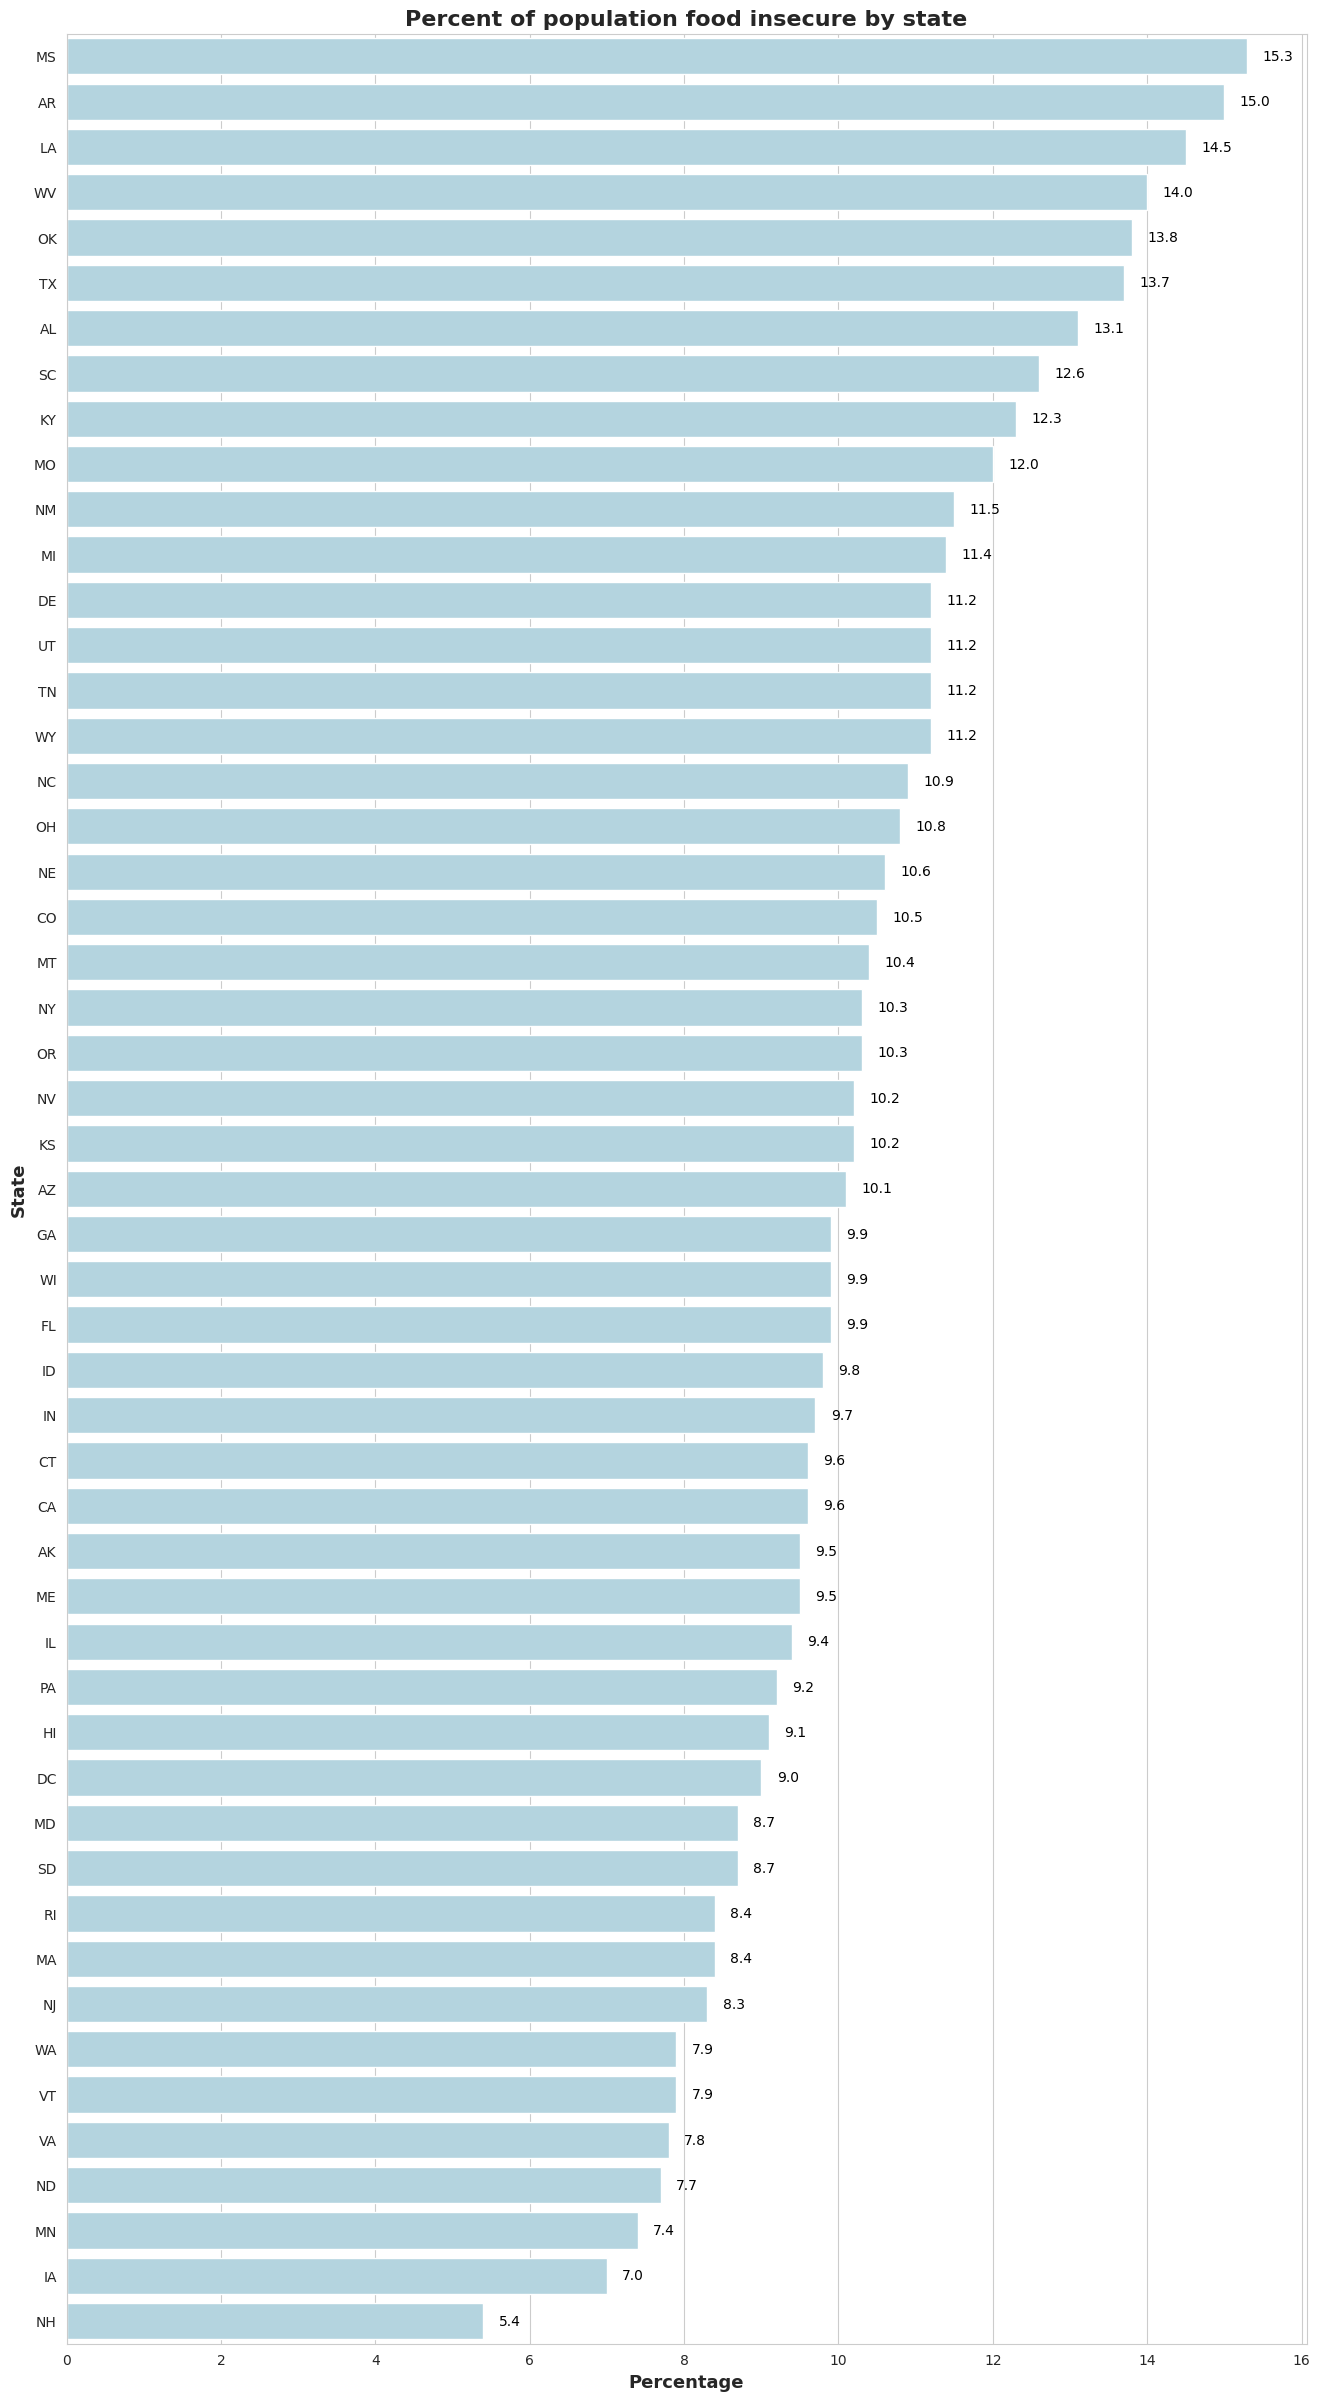

In [41]:
# Make a horizontal bar chart of state food insecurity rates using Seaborn
visframetest = gdf.sort_values('pct_food_insecure',ascending=False)[:100]

#Horizontal barchart for identifying similar values from AK and HI
sns.set_style('whitegrid')
fig,ax=plt.subplots(figsize=(16,30))
chart1 = sns.barplot(x=visframetest['pct_food_insecure'],y=visframetest['state'],color='lightblue')
chart1.set_title('Percent of population food insecure by state',weight='bold',fontsize=16)
chart1.set_xlabel('Percentage',weight='bold',fontsize=13)
chart1.set_ylabel('State', weight='bold',fontsize=13)

for i, v, in enumerate(visframetest['pct_food_insecure']):
    ax.text(v + 0.2, i, str(v), color='black', fontsize=10, ha='left', va='center')

plt.show()

We can see Maine and Alaska with 9.5 and Hawaii, District of Columbia and Pennsylvania around 9.1. If we compare then on the map, we can see very similar colors, prooving the map is correct.

That closes the article for plotting information on maps. Very useful and easy to go through. Thank you Alex.